Number of positive sequences: 137
Number of negative sequences (raw): 3163
Positive sequence length: 17
Number of processed negative sequences: 3163
Total balanced sequences: 6326
Balanced positive count: 3163; negative count: 3163
X_data shape: (6326, 68)
y_data shape: (6326, 1)


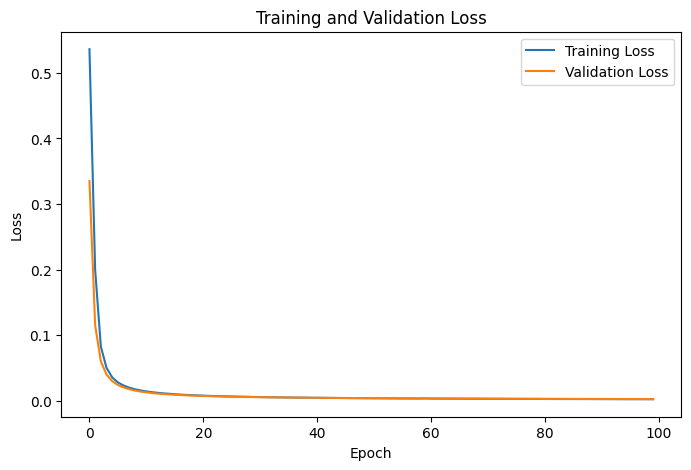

Validation Accuracy: 0.9992101105845181


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from nn.nn import NeuralNetwork

# --- 1. Load the Data ---
positive_file_path = "data/rap1-lieb-positives.txt"
negative_file_path = "data/yeast-upstream-1k-negative.fa"

# Read positive examples (each is a short DNA sequence)
positive_seqs = read_text_file(positive_file_path)  # returns List[str]
print(f"Number of positive sequences: {len(positive_seqs)}")

# Read negative examples from the FASTA file.
negative_seqs_raw = read_fasta_file(negative_file_path)  # returns List[str]
print(f"Number of negative sequences (raw): {len(negative_seqs_raw)}")

# --- 2. Process Negative Sequences ---
# Assume that all positive sequences have the same length.
window_length = len(positive_seqs[0])
print("Positive sequence length:", window_length)

def extract_window(seq, length):
    """Extract a random window of given length from seq if possible."""
    if len(seq) < length:
        return None
    start = np.random.randint(0, len(seq) - length + 1)
    return seq[start:start+length]

# Process negatives: for each negative sequence, extract one random window of the same length.
negative_seqs = []
for seq in negative_seqs_raw:
    window = extract_window(seq, window_length)
    if window is not None:
        negative_seqs.append(window)
print(f"Number of processed negative sequences: {len(negative_seqs)}")

# --- 3. Combine and Balance Classes ---
# Create labels: positive=True, negative=False
pos_labels = [True] * len(positive_seqs)
neg_labels = [False] * len(negative_seqs)

# Combine sequences and labels.
all_seqs = positive_seqs + negative_seqs
all_labels = pos_labels + neg_labels

# Use your sample_seqs function to balance classes.
balanced_seqs, balanced_labels = sample_seqs(all_seqs, all_labels)
print(f"Total balanced sequences: {len(balanced_seqs)}")
print(f"Balanced positive count: {sum(balanced_labels)}; negative count: {len(balanced_labels) - sum(balanced_labels)}")

# --- 4. One-Hot Encode the Sequences ---
# Each sequence is one-hot encoded to a vector of length (window_length * 4)
X_data = one_hot_encode_seqs(balanced_seqs)
print("X_data shape:", X_data.shape)

# Convert labels to a numpy array of shape (n_samples, 1), casting booleans to floats (1.0/0.0)
y_data = np.array(balanced_labels, dtype=float).reshape(-1, 1)
print("y_data shape:", y_data.shape)

# --- 5. Split the Data ---
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# --- 6. Create the Neural Network Classifier ---
# Input dimension equals window_length * 4.
input_dim = X_data.shape[1]  
# We choose a simple architecture: one hidden layer of 32 neurons and an output layer of 1 neuron with sigmoid activation.
nn_arch = [
    {'input_dim': input_dim, 'output_dim': 32, 'activation': 'relu'},
    {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}
]
lr = 0.01
seed = 42
batch_size = 16
epochs = 100
loss_function = "binary_cross_entropy"  # Appropriate for binary classification.

classifier = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)

# --- 7. Train the Classifier ---
train_losses, val_losses = classifier.fit(X_train, y_train, X_val, y_val)

# Plot training and validation loss by epoch.
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# --- 8. Evaluate the Classifier ---
# Get predictions from your model.
y_pred = classifier.predict(X_val)
# Y_pred is out of shape (1, n_samples); so transpose it.
if y_pred.shape[0] == 1 and y_pred.shape[1] != 1:
    y_pred = y_pred.T

# Convert probabilities to binary predictions (threshold at 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Compute accuracy.
accuracy = np.mean(y_pred_binary == y_val)
print("Validation Accuracy:", accuracy)

Explanation of loss function and hyperparameters

chose binary cross ternopy because better at classification

Text(0.5, 0, 'Position')

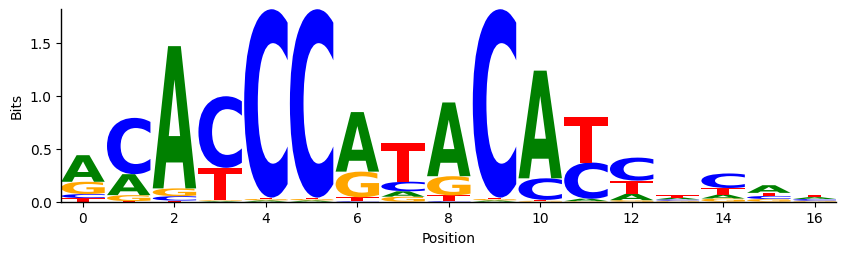

In [16]:
# Generate a seqlogo for validation with information content
import logomaker
from nn.io import read_fasta_file

# Read the sequences from the FASTA file
fasta_file_path = "data/rap1-pos.fa"
sequences = read_fasta_file(fasta_file_path)

# Create a DataFrame for the sequence logo with information content
info_matrix = logomaker.alignment_to_matrix(sequences, to_type='information')

# Generate the sequence logo
logo = logomaker.Logo(info_matrix)
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.ax.set_ylabel('Bits')
logo.ax.set_xlabel('Position')

In [8]:
# Check a positive hit (found in training set)
pos = one_hot_encode_seqs(["ACACCCATACACCAAAC"])
print(classifier.predict(pos))

[[0.99996045]]


In [9]:
# Check a predicted positive hit (not found in training set,but should be a positive hit based on the motif)
predicted_pos = one_hot_encode_seqs(["AAACCCAGACACCCAGA"])
print(classifier.predict(predicted_pos))

[[0.9989134]]


In [11]:
# Check a completely random sequence
test_rand = one_hot_encode_seqs(["TATATATTAAATATATA"])
print(classifier.predict(test_rand))

array([[1.45622237e-07]])

In [14]:
# Check another predicted positive hit (not found in training set,but should be a positive hit based on the motif)
test_predicted_pos = one_hot_encode_seqs(["ACACCCATACATCTCAT"])
print(classifier.predict(test_predicted_pos))

[[0.99997312]]


In [20]:
# Check a minimal predicted positive hit (not found in training set,but should be a positive hit based on the motif)
test_min = one_hot_encode_seqs(["TAAGCCCTGCACTTCAT"])
print(classifier.predict(test_min))

[[0.85864666]]


In [21]:
# does not acurately predict rev complement
test_rev_comp = one_hot_encode_seqs(["GTTTGGTGTATGGGTGT"])
test_no_rev_comp = one_hot_encode_seqs(["ACACCCATACACCAAAC"])  #in rap1-lieb-positives.txt

print(classifier.predict(test_rev_comp))
print(classifier.predict(test_no_rev_comp))

[[7.55591018e-09]]
[[0.99996045]]
